In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!nvidia-smi

Thu Aug 17 01:49:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   49C    P8    19W / 175W |    590MiB /  8192MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           TCC  | 00000000:02:00.0 Off |                  Off |
| N/A   

In [3]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

ModuleNotFoundError: No module named 'keras'

In [4]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    # jid可以理解为每个用户的在某个渠道上的转化（触达）情况，对应多campaign为对应渠道
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

# 最少有多少个用户触达
def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]


def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)


def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    
    return df_ext

In [5]:
# data_file = '/kaggle/input/hoho-criteo/criteo_attribution_dataset.tsv/pcb_dataset_final.tsv'
# df0 = pd.read_csv(data_file, sep='\t', nrows = 500000)

data_file = r"F:\AI\hoho_python_bigdata_ml\data\criteo\criteo_attribution_dataset\criteo_attribution_dataset.tsv.gz"
df0 = pd.read_csv(data_file, sep = "\t", compression = "gzip")

In [6]:
len(df0)

16468027

In [50]:
df0_hoho = df0.sample(int(len(df0) * 0.5)) 

In [51]:
df_demo = df0.sample(100)

In [52]:
df_demo.groupby(['uid'])['campaign'].count().reset_index(name = 'count')

,uid,count
0,770228,1
1,906226,1
2,1010369,1
3,1137019,1
4,1628385,1
...,...,...
95,30630104,1
96,30765709,1
97,30847663,1
98,31741231,1


In [53]:
n_campaigns = 400

df1 = add_derived_columns(df0_hoho)

In [54]:
df1_demo = df1.head(100)

In [55]:
df1_demo

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm
5319260,827577,16655149,716288,0,-1,-1,0,0,-1,-1,...,24498970,29196072,11409686,26597096,30948668,29196072,29196072,16655149_-1,0.309814,0.000000
9921118,1600147,19159597,5442463,0,-1,-1,0,0,-1,-1,...,5099858,17152695,32440044,20754141,9312274,29196072,18291872,19159597_-1,0.599037,0.821928
1827435,303297,7305185,26321366,0,-1,-1,0,0,-1,-1,...,22792619,29196072,5824239,1973606,12551322,14911188,18291872,7305185_-1,0.113543,0.888619
8937877,1419509,8652845,28795042,0,-1,-1,0,0,-1,-1,...,23137540,29196072,32440044,1973606,9312274,26597096,8661620,8652845_-1,0.531412,0.330615
3688335,572100,27666729,28351001,0,-1,-1,0,1,-1,-1,...,23322867,29196072,5824236,29196072,16628728,29196072,22419790,27666729_-1,0.214173,0.000036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009165,628690,26114996,23530192,0,-1,-1,0,0,-1,-1,...,11798878,29196072,32440047,5824238,9068209,29196072,18291877,26114996_-1,0.235358,0.698779
11604760,1857108,26498846,497593,0,-1,-1,0,0,-1,-1,...,3018159,29196072,11409686,1973606,11005100,29841067,29520626,26498846_-1,0.695234,0.058111
9058526,1435490,23131263,17091415,0,-1,-1,0,0,-1,-1,...,13326150,29196072,32440044,28928366,6886758,29196072,29196072,23131263_-1,0.537395,0.000000
16296931,2649187,13206989,17686799,0,-1,-1,0,0,-1,-1,...,20239695,29196072,32440044,29196072,11871047,29196072,29196072,13206989_-1,0.991759,0.000000


In [56]:
df1_demo['jid'].value_counts().values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [57]:
df2 = sample_campaigns(df1, n_campaigns)
len(df2)

5124316

In [58]:
df3 = filter_journeys_by_length(df2, 2)
len(df3)

3209070

In [59]:
len(df3[df3['conversion'] == 1]), len(df3[df3['conversion'] == 0])

(117030, 3092040)

In [60]:
df4 = balance_conversions(df3)
len(df4)

235593

In [61]:
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [62]:
len(df6)

235593

In [63]:
df6.sample(5)
# 可以将campaign理解为一个渠道

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
214757,2489444,30071686,32135670,1,2809345,10414442,0,1,12,31,...,32440044,1973606,9312274,9068204,6083947,30071686_10414442,0.931957,0.000422,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
231950,653733,15037277,30491418,0,-1,-1,0,0,-1,-1,...,5824237,1973606,30545032,20754144,8661623,15037277_-1,0.244733,0.271376,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
99493,2630930,15386387,10341182,1,3056206,6830883,0,1,4,7,...,32440044,32440043,31785010,29196072,29520629,15386387_6830883,0.984925,0.031570,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
192397,2098570,15664388,30368132,1,2100510,5306926,1,1,1,2,...,5824237,1973606,27924429,26597096,21091111,15664388_5306926,0.785628,0.135481,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
215778,242872,9349299,26998428,0,-1,-1,0,0,-1,-1,...,32440044,29196072,10191465,29196072,18291877,9349299_-1,0.090922,0.533667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [64]:
df6['campaign'].value_counts()

10341182    18782
15398570    13195
30801593     9237
29427842     6548
17686799     6318
            ...  
16184514        5
15518374        4
28328731        2
31427832        2
21443097        1
Name: campaign, Length: 399, dtype: int64

In [65]:
print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

235593
[118563, 117030]


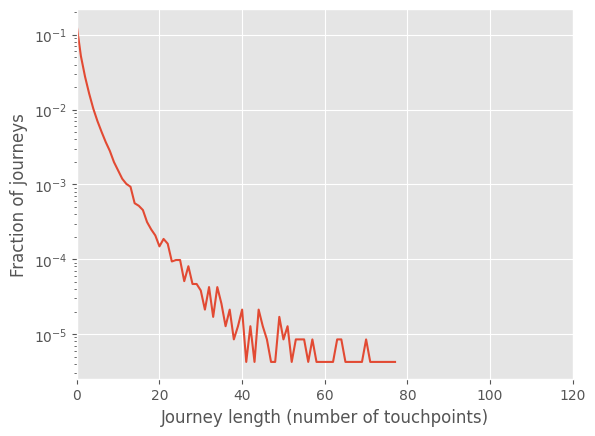

In [66]:
def journey_length_histogram(df):
    counts = df.groupby(["jid"])["uid"].count().reset_index(name = "count").groupby(["count"]).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_histogram(df4)

plt.plot(range(len(hist_x)), hist_y, label = "all journeys")
plt.yscale("log")
plt.xlim(0, 120)
plt.xlabel("Journey length (number of touchpoints)")
plt.ylabel("Fraction of journeys")
plt.show()

In [67]:
def last_touch_attribution(df):
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters

    campaign_impressions = count_by_campaign(df)  # 每个活动的次数
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm'] #找到时间戳最大那行，即最近转化的那行，即找到最后触达的渠道
    campaign_conversions = count_by_campaign(df_converted[idx])
    
    result = np.zeros(n_campaigns)
    idx = 0
    for idx, (conversion, impression) in enumerate(zip(campaign_conversions, campaign_impressions)):
        if impression == 0:
            result[idx] = 0.0
        else:
            result[idx] = conversion / impression
    return result
#     return campaign_conversions / campaign_impressions  
    

In [68]:
lta = last_touch_attribution(df6) # LTA模型进行归因分析

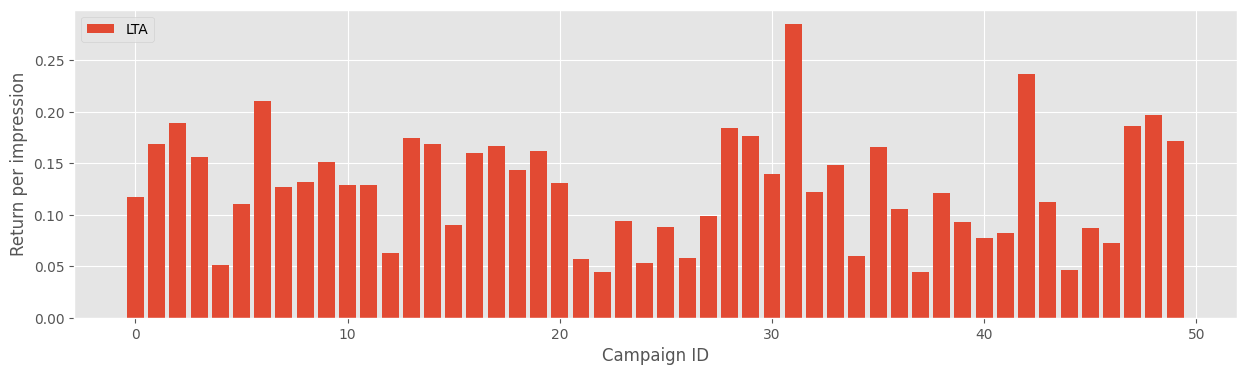

In [69]:
# Visualization of the attribution scores

campaign_idx = range(150, 200)
# campaign_idx = range(lta.shape[0])

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [70]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
 
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [71]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(62676, 1533)


In [72]:
print(y.shape)

(62676,)


In [73]:
from sklearn.model_selection import train_test_split

In [74]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [75]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8363911933631142


D:\ProgramData\Anaconda3\envs\hoho_chatgpt\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
!pip show keras

Name: keras
Version: 2.13.1
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: d:\programdata\anaconda3\envs\hoho_chatgpt\lib\site-packages
Requires: 
Required-by: tensorflow-intel


In [76]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
314/314 [==============================] - 1s 3ms/step - loss: 0.5907 - accuracy: 0.7470 - val_loss: 0.5373 - val_accuracy: 0.7849
Epoch 2/10
314/314 [==============================] - 0s 1ms/step - loss: 0.5144 - accuracy: 0.7971 - val_loss: 0.4961 - val_accuracy: 0.7936
Epoch 3/10
314/314 [==============================] - 0s 2ms/step - loss: 0.4860 - accuracy: 0.8031 - val_loss: 0.4775 - val_accuracy: 0.7999
Epoch 4/10
314/314 [==============================] - 0s 1ms/step - loss: 0.4707 - accuracy: 0.8087 - val_loss: 0.4659 - val_accuracy: 0.8059
Epoch 5/10
314/314 [==============================] - 0s 2ms/step - loss: 0.4603 - accuracy: 0.8134 - val_loss: 0.4576 - val_accuracy: 0.8104
Epoch 6/10
314/314 [==============================] - 0s 1ms/step - loss: 0.4524 - accuracy: 0.8169 - val_loss: 0.4513 - val_accuracy: 0.8136
Epoch 7/10
314/314 [==============================] - 0s 1ms/step - loss: 0.4462 - accuracy: 0.8187 - val_loss: 0.4461 - val_accuracy: 0.8162
Epoch 

In [58]:
# pytorch形式

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

# Assuming 'x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test' are your training, validation, and testing data
# Make sure they are converted to torch tensors or numpy arrays before proceeding.

class ContributionsModel(nn.Module):
    def __init__(self, input_dim):
        super(ContributionsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x

input_dim = np.shape(x_train)[1]
model = ContributionsModel(input_dim)

criterion = nn.BCELoss()
# optimizer = optim.RMSprop(model.parameters())
optimizer = optim.Adam(model.parameters(), lr = 0.005)

# Convert the data to torch tensors if they are not already in that format
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_train = torch.unsqueeze(y_train, 1)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_val = torch.unsqueeze(y_val, 1)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
y_test = torch.unsqueeze(y_test, 1)

print(f"input size: {x_train.shape}, target size: {y_train.shape}")

# Training loop
batch_size = 128
epochs = 10
num_batches = len(x_train) // batch_size

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        inputs, targets = x_train[start_idx:end_idx], y_train[start_idx:end_idx]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation
model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs, y_test)
    test_accuracy = ((test_outputs >= 0.5) == y_test).float().mean()

print('Test loss:', test_loss.item())
print('Test accuracy:', test_accuracy.item())


input size: torch.Size([75604, 1621]), target size: torch.Size([75604, 1])
Epoch 1/10, Loss: 0.4671
Epoch 2/10, Loss: 0.3982
Epoch 3/10, Loss: 0.3800
Epoch 4/10, Loss: 0.3688
Epoch 5/10, Loss: 0.3610
Epoch 6/10, Loss: 0.3553
Epoch 7/10, Loss: 0.3508
Epoch 8/10, Loss: 0.3472
Epoch 9/10, Loss: 0.3443
Epoch 10/10, Loss: 0.3419
Test loss: 0.35289812088012695
Test accuracy: 0.8592711687088013


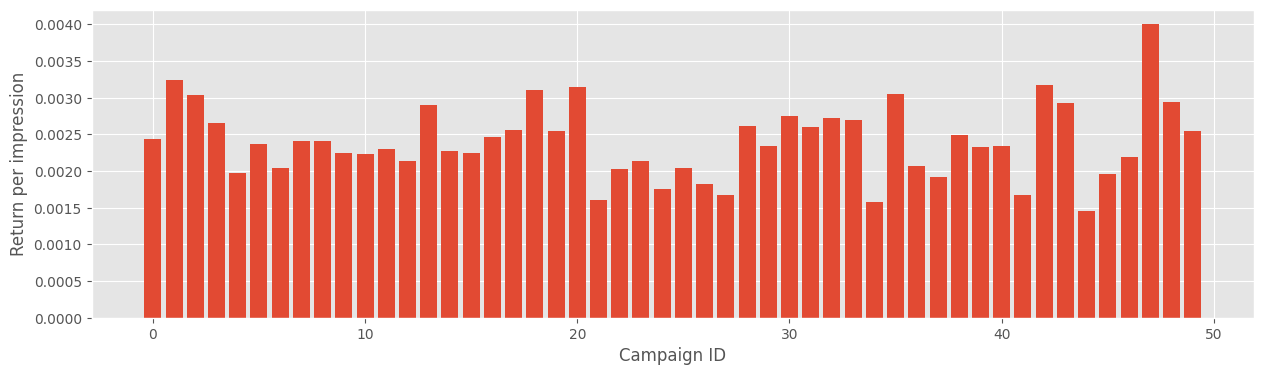

In [77]:
# # Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

# 用普通的一层神经网络的归因分析，网络的权重即每个渠道的贡献度
# model.eval()
# with torch.no_grad():
#     weights = model.fc1.weight.squeeze().detach().numpy()  # Get the model's weights and convert to numpy
# #     print(f"weights: {weights}")
#     weights = weights[np.newaxis, :]
# #     print(f"2. weights: {weights}")
#     keras_logreg = softmax(weights)[0:n_campaigns].flatten()

# fig = plt.figure(figsize=(15,4))
# ax = fig.add_subplot(111)
# plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
# plt.xlabel('Campaign ID')
# plt.ylabel('Return per impression')
# plt.show()

In [78]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
#     print(f"x2d: {x2d}")
#     print(f"cumsum: {np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])[1]}")
    
    # 将x2d划分为一行一个样本，每个样本包含这些特征：'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion'
    # 其实直接将x2d除第1列之外的特征提取出来不就行了？！绕来绕去的
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1]) 
    
#     print(f"x3d_list: {x3d_list[0]}")
    
    x3d = []
    y = []
    
    for idx, xi in enumerate(x3d_list):
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi) 
        # 把xi每个特征水平拉平为一行数值特征（原本每个特征维度是分开的）
        # 注意：journey_matrix依然是二维的
        
#         if idx == 0:
#             print(f"xi: {xi}")
#             print(f"journey_matrix: {journey_matrix}")
#             print(f"argsort: {journey_matrix[:, 5].argsort() }")
#             print(f"argsorted: {journey_matrix[ journey_matrix[:, 5].argsort() ] }")
#         print(f"num of journey: {len(journey_matrix)}")
        
        
#         journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        journey_matrix = journey_matrix[ journey_matrix[:, -2].argsort() ] # sort impressions by timestamp
        # 基于时间排序，这里就相当于得出每个用户的触达路径（即转化路径），最长为max_touchpoints个长度
        # 这里有问题吧：已经将数组拉平了，第5个位置就不是timestamp了，倒数第2个索引才是
        
        n_touchpoints = len(journey_matrix)
        
#         if idx == 0:
#             print(f"n_touchpoints: {n_touchpoints}")
        
        
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
        
#         if idx == 0:
#             print(f"padded_journey: {padded_journey}")
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y



In [48]:
#demo
_, _ = features_for_lstm(df6.sample(10), 15)

In [79]:
x, y = features_for_lstm(df6, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

# 注意：这里有坑，要转为numpy数组
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

(62676, 15, 1535)


In [80]:
x[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.22987574e-04, 1.04855284e-01, 2.17131121e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.46713297e-04, 1.10532365e-03, 4.64211363e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [81]:
# 普通LSTM

from keras.models import Sequential 
from keras.layers import Dense, LSTM
import numpy as np

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, np.array(y_train), batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/5
627/627 [==============================] - 92s 133ms/step - loss: 0.3206 - accuracy: 0.8611 - val_loss: 0.3111 - val_accuracy: 0.8788
Epoch 2/5
627/627 [==============================] - 73s 116ms/step - loss: 0.2949 - accuracy: 0.8739 - val_loss: 0.2848 - val_accuracy: 0.8881
Epoch 3/5
627/627 [==============================] - 70s 112ms/step - loss: 0.2846 - accuracy: 0.8792 - val_loss: 0.2646 - val_accuracy: 0.8944
Epoch 4/5
627/627 [==============================] - 69s 110ms/step - loss: 0.2729 - accuracy: 0.8839 - val_loss: 0.2536 - val_accuracy: 0.8948
Epoch 5/5
627/627 [==============================] - 69s 110ms/step - loss: 0.2630 - accuracy: 0.8902 - val_loss: 0.2502 - val_accuracy: 0.8973
Test score: 0.24817611277103424
Test accuracy: 0.8974154591560364


In [81]:
### 用pytorch实现

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming x_train, y_train, x_val, y_val, x_test, and y_test are available

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=0.2, bidirectional=False)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Select only the output of the last time step
        out = self.fc(out)
        out = torch.sigmoid(out)  # Apply sigmoid activation for binary classification
        return out

# Define the hyperparameters
n_steps, n_features = x_train.shape[1:]

# Instantiate the model
hidden_size = 64
output_size = 1
model = LSTMModel(n_features, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters())

# Training loop
batch_size = 64
epochs = 5

for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        inputs = x_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    with torch.no_grad():
        val_outputs = model(x_val)
        val_loss = criterion(val_outputs.squeeze(), y_val)
    
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Test the model
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_accuracy = ((test_outputs >= 0.5) == y_test).float().mean()


print('Test Loss:', test_loss.item())
print('Test accuracy: ', test_accuracy.item())


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch [1/5], Loss: 0.6568, Val Loss: 0.6680
Epoch [2/5], Loss: 0.6542, Val Loss: 0.6674
Epoch [3/5], Loss: 0.6529, Val Loss: 0.6672
Epoch [4/5], Loss: 0.6521, Val Loss: 0.6672
Epoch [5/5], Loss: 0.6515, Val Loss: 0.6672
Test Loss: 0.6624795794487
Test accuracy:  0.6232876777648926


In [82]:
# LSTM with Attention

from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]
print(f"x: {x.shape}")

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)
print(f"embeddings: {embeddings.shape}")

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)
print(f"LSTM|activations: {activations.shape}")

attention = Dense(1, activation='tanh')(activations)
print(f"Dense|attention: {attention.shape}")

attention = Flatten()(attention)
print(f"Flatten|attention: {attention.shape}")

attention = Activation('softmax', name = 'attention_weigths')(attention)  # 对每个渠道作归一化
print(f"Activation|attention: {attention.shape}")

attention = RepeatVector(hidden_units * 1)(attention)
print(f"RepeatVector|attention: {attention.shape}")

attention = Permute([2, 1])(attention)
print(f"Permute|attention: {attention.shape}")

weighted_activations = Multiply()([activations, attention])  # activations是LSTM的输出
print(f"Multiply|weighted_activations: {weighted_activations.shape}")

weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)
print(f"sum|weighted_activations: {weighted_activations.shape}")

main_output = Dense(1, activation='sigmoid')(weighted_activations)
print(f"main_output: {main_output.shape}")

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

x: (62676, 15, 1535)
embeddings: (None, 15, 128)
LSTM|activations: (None, 15, 64)
Dense|attention: (None, 15, 1)
Flatten|attention: (None, 15)
Activation|attention: (None, 15)
RepeatVector|attention: (None, 64, 15)
Permute|attention: (None, 15, 64)
Multiply|weighted_activations: (None, 15, 64)
sum|weighted_activations: (None, 64)
main_output: (None, 1)
Epoch 1/10
627/627 [==============================] - 18s 24ms/step - loss: 0.2777 - accuracy: 0.8839 - val_loss: 0.2359 - val_accuracy: 0.9027
Epoch 2/10
627/627 [==============================] - 14s 22ms/step - loss: 0.2313 - accuracy: 0.9033 - val_loss: 0.2291 - val_accuracy: 0.9044
Epoch 3/10
627/627 [==============================] - 13s 21ms/step - loss: 0.2245 - accuracy: 0.9065 - val_loss: 0.2285 - val_accuracy: 0.9037
Epoch 4/10
627/627 [==============================] - 13s 20ms/step - loss: 0.2212 - accuracy: 0.9076 - val_loss: 0.2293 - val_accuracy: 0.9037
Epoch 5/10
627/627 [==============================] - 13s 21ms/step -

In [91]:
# pytorch形式
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming 'x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test' are the training, validation, and test data arrays

    
class AttentionLSTM(nn.Module):
    def __init__(self, n_steps, n_features, hidden_units):
        super(AttentionLSTM, self).__init__()
        
        self.hidden_units = hidden_units
        self.embeddings = nn.Linear(n_features, 128)
        self.lstm = nn.LSTM(128, hidden_units, dropout=0.2, batch_first=True)
        self.attention = nn.Linear(hidden_units, 1)
        self.flatten = nn.Flatten()
        self.softmax = nn.Softmax(dim=1)
        self.multiply = torch.mul
        self.sum = torch.sum
        self.output_layer = nn.Linear(hidden_units, 1)

    def forward(self, x):
#         print(f"x: {x.shape}")
        
        embeddings = self.embeddings(x)
#         print(f"embeddings: {embeddings.shape}")
        
        activations, _ = self.lstm(embeddings)
#         print(f"lstm|activations: {activations.shape}")
        
        attention = self.attention(activations)
#         print(f"attention|attention: {attention.shape}")
        
        attention = self.flatten(attention)
#         print(f"flatten|attention: {attention.shape}")
        
        attention = self.softmax(attention)
#         print(f"softmax|attention: {attention.shape}")
        
        attention = attention.unsqueeze(2)
#         print(f"unsqueeze|attention: {attention.shape}")
        
        attention = torch.repeat_interleave(attention, repeats = self.hidden_units, axis = 2)
#         print(f"repeat|attention: {attention.shape}")
        

        weighted_activations = self.multiply(activations, attention)
#         print(f"multiply|weighted_activations: {weighted_activations.shape}")
        
        weighted_activations = self.sum(weighted_activations, dim=1)
#         print(f"sum|weighted_activations: {weighted_activations.shape}")

        main_output = self.output_layer(weighted_activations)
#         print(f"output_layer|main_output: {main_output.shape}")
        
        main_output = torch.sigmoid(main_output)
#         print(f"sigmoid|main_output: {main_output.shape}")
        
        return main_output

n_steps, n_features = x_train.shape[1:3]
hidden_units = 64

model = AttentionLSTM(n_steps, n_features, hidden_units)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

def train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs=5, batch_size=64):
    for epoch in range(epochs):
        model.train()
        for i in range(0, len(x_train), batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]
            
            optimizer.zero_grad()
            outputs = model(batch_x)
#             print(f"outputs: {outputs.squeeze().shape}, {batch_y.shape}")
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs.squeeze(), y_val)
            print(f'Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss.item():.4f}')

train_model(model, optimizer, criterion, x_train, y_train, x_val, y_val, epochs=10)

model.eval()
with torch.no_grad():
    test_outputs = model(x_test)
    test_loss = criterion(test_outputs.squeeze(), y_test)
    test_accuracy = ((torch.sigmoid(test_outputs) > 0.5).float() == y_test).float().mean().item()

print('Test Loss:', test_loss.item())
print('Test Accuracy:', test_accuracy)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Validation Loss: 0.6612
Epoch 2/10, Validation Loss: 0.5858
Epoch 3/10, Validation Loss: 0.5432
Epoch 4/10, Validation Loss: 0.5461
Epoch 5/10, Validation Loss: 0.5471
Epoch 6/10, Validation Loss: 0.5251
Epoch 7/10, Validation Loss: 0.5275
Epoch 8/10, Validation Loss: 0.5250
Epoch 9/10, Validation Loss: 0.5227
Epoch 10/10, Validation Loss: 0.5226
Test Loss: 0.5060881972312927
Test Accuracy: 0.6232876777648926


In [72]:
# 为什么同样的神经网络架构，这里使用keras效果比pytorch要好？

In [30]:
model.input

<KerasTensor: shape=(None, 15, 994) dtype=float32 (created by layer 'input_1')>

In [83]:
# Analysis of LSTM-A Model
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])  # 还记得每个样本，开头n_campaigns个特征为每个渠道campaign

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)
print(f"input shape: {x_train.shape}")
print(f"attentions shape: {a.shape}")

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    # journey为转化路径
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

1254/1254 [==============================] - 6s 4ms/step
input shape: (40112, 15, 1535)
attentions shape: (40112, 15)


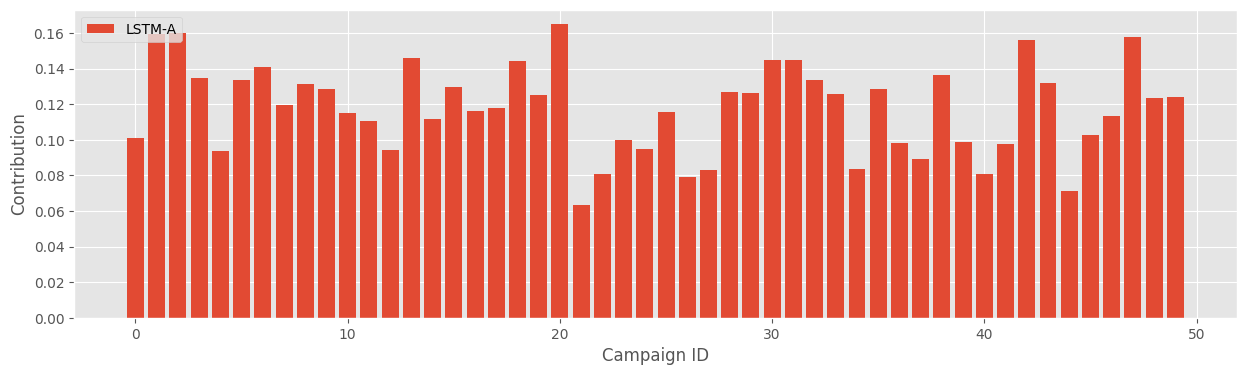

In [85]:
lstm_a = (attributions/campaign_freq)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

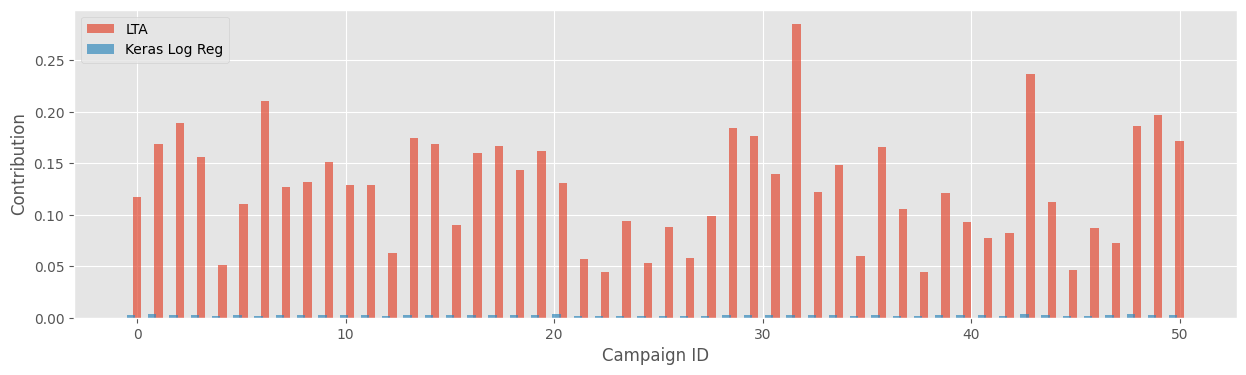

In [86]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(keras_logreg[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, keras_logreg[campaign_idx], width=0.4, alpha=0.7, label='Keras Log Reg' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

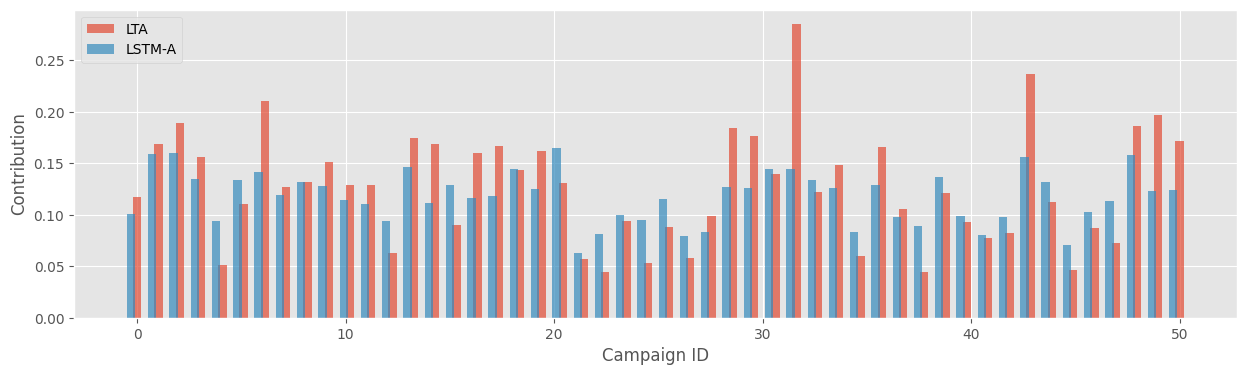

In [87]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(lstm_a[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lstm_a[campaign_idx], width=0.4, alpha=0.7, label='LSTM-A'  )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

In [88]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    # 根据归因值 attribution 将总预算 budget_total 分配给各个活动，并向上取整得到 budgets 数组，表示每个活动可用的预算上限
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:  # 大于1表示该活动还有预算
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [92]:
np.sum(lstm_a)

47.088102908950674

In [93]:

pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg, lstm_a]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch, verbose = True)
        print('{} {} : {}'.format(i, j, reward))

[28. 25. 26. 25. 26. 27. 25. 24. 26. 26. 20. 27. 25. 27. 28. 25. 26. 27.
 24. 27. 27. 26. 26. 27. 25. 28. 25. 26. 27. 26. 27. 28. 24. 26. 26. 23.
 27. 22. 27. 22. 28. 27. 24. 24. 24. 25. 27. 25. 27. 26. 25. 27. 26. 26.
 24. 26. 27. 27. 28. 27. 26. 25. 26. 28. 24. 25. 25. 26. 25. 27. 27. 24.
 26. 27. 26. 29. 27. 28. 28. 26. 26. 24. 25. 28. 28. 28. 28. 25. 25. 25.
 29. 25. 26. 27. 26. 26. 28. 27. 28. 26. 26. 23. 25. 26. 26. 25. 27. 28.
 25. 27. 27. 25. 28. 27. 23. 25. 22. 27. 26. 26. 25. 26. 25. 27. 23. 27.
 22. 28. 23. 29. 26. 24. 24. 28. 26. 26. 26. 28. 25. 27. 24. 25. 24. 28.
 27. 27. 25. 26. 25. 28. 26. 27. 27. 26. 24. 26. 27. 26. 26. 26. 26. 26.
 24. 27. 27. 25. 27. 27. 26. 27. 26. 24. 23. 25. 24. 25. 24. 25. 27. 27.
 26. 28. 26. 26. 24. 27. 25. 23. 26. 25. 25. 25. 28. 26. 24. 25. 25. 27.
 27. 27. 26. 25. 24. 26. 27.  0. 24. 26. 26. 27. 23. 26. 25. 27. 26. 28.
 27. 29. 26. 28. 22. 25. 25. 27. 24. 29. 25. 27. 25. 27. 23. 27. 22. 28.
 26. 28. 24. 25. 28. 26. 28. 28. 27. 27. 27. 26. 25

4.24% : 41.74% budget spent
8.49% : 58.82% budget spent
12.73% : 68.96% budget spent
16.98% : 75.47% budget spent
21.22% : 79.33% budget spent
25.47% : 82.83% budget spent
29.71% : 85.46% budget spent
33.96% : 87.33% budget spent
38.20% : 88.70% budget spent
42.45% : 89.92% budget spent
46.69% : 91.02% budget spent
50.94% : 92.03% budget spent
55.18% : 92.78% budget spent
59.42% : 93.48% budget spent
63.67% : 94.12% budget spent
67.91% : 94.60% budget spent
72.16% : 94.99% budget spent
76.40% : 95.30% budget spent
80.65% : 95.65% budget spent
84.89% : 95.84% budget spent
89.14% : 96.06% budget spent
93.38% : 96.24% budget spent
97.63% : 96.46% budget spent
1 0 : 366
[29. 23. 26. 25. 23. 27. 23. 22. 25. 23. 24. 26. 25. 26. 28. 26. 25. 26.
 23. 27. 25. 25. 26. 25. 25. 28. 25. 25. 25. 25. 26. 27. 23. 23. 26. 22.
 31. 21. 27. 25. 26. 26. 25. 24. 24. 25. 29. 24. 26. 25. 24. 27. 26. 28.
 24. 26. 25. 26. 27. 27. 24. 23. 25. 26. 24. 25. 25. 26. 24. 25. 26. 23.
 25. 25. 25. 28. 26. 28. 28. 24. 

4.24% : 40.82% budget spent
8.49% : 57.72% budget spent
12.73% : 67.82% budget spent
16.98% : 74.19% budget spent
21.22% : 78.20% budget spent
25.47% : 81.74% budget spent
29.71% : 84.55% budget spent
33.96% : 86.43% budget spent
38.20% : 87.81% budget spent
42.45% : 89.05% budget spent
46.69% : 90.19% budget spent
50.94% : 91.24% budget spent
55.18% : 91.99% budget spent
59.42% : 92.73% budget spent
63.67% : 93.34% budget spent
67.91% : 93.89% budget spent
72.16% : 94.30% budget spent
76.40% : 94.61% budget spent
80.65% : 94.95% budget spent
84.89% : 95.18% budget spent
89.14% : 95.37% budget spent
93.38% : 95.52% budget spent
97.63% : 95.80% budget spent
2 1 : 337
[31. 23. 25. 24. 25. 26. 24. 21. 24. 25. 18. 29. 27. 25. 30. 26. 25. 28.
 22. 27. 28. 28. 27. 25. 27. 30. 23. 25. 30. 28. 29. 29. 23. 26. 25. 21.
 31. 21. 28. 19. 29. 28. 24. 23. 22. 23. 31. 22. 28. 26. 23. 29. 27. 27.
 20. 26. 26. 28. 28. 30. 24. 22. 28. 29. 20. 24. 23. 26. 24. 27. 30. 21.
 27. 27. 27. 31. 27. 31. 31. 25. 

4.24% : 42.67% budget spent
8.49% : 59.46% budget spent
12.73% : 69.72% budget spent
16.98% : 76.07% budget spent
21.22% : 80.05% budget spent
25.47% : 83.57% budget spent
29.71% : 86.27% budget spent
33.96% : 88.28% budget spent
38.20% : 89.76% budget spent
42.45% : 91.08% budget spent
46.69% : 92.06% budget spent
50.94% : 93.08% budget spent
55.18% : 93.96% budget spent
59.42% : 94.64% budget spent
63.67% : 95.16% budget spent
67.91% : 95.60% budget spent
72.16% : 95.99% budget spent
76.40% : 96.24% budget spent
80.65% : 96.53% budget spent
84.89% : 96.68% budget spent
89.14% : 96.87% budget spent
93.38% : 97.01% budget spent
97.63% : 97.22% budget spent
3 2 : 353
[ 64.  11.  25.  13.  17.  33.  13.   5.  17.  16.   1.  43.  14.  27.
  62.  12.  15.  28.   5.  36.  35.  22.  15.  32.   9.  72.  12.  16.
  34.  15.  32.  57.   5.  22.  21.   5.  40.   3.  35.   2.  50.  33.
   7.   5.   7.  12.  42.  11.  31.  19.  11.  39.  17.  21.   8.  15.
  31.  43.  51.  37.  19.  11.  23.  51. 

4.24% : 37.07% budget spent
8.49% : 50.90% budget spent
12.73% : 58.46% budget spent
16.98% : 63.51% budget spent
21.22% : 66.99% budget spent
25.47% : 70.23% budget spent
29.71% : 72.87% budget spent
33.96% : 74.83% budget spent
38.20% : 76.56% budget spent
42.45% : 78.10% budget spent
46.69% : 79.35% budget spent
50.94% : 80.51% budget spent
55.18% : 81.44% budget spent
59.42% : 82.34% budget spent
63.67% : 83.27% budget spent
67.91% : 84.07% budget spent
72.16% : 84.78% budget spent
76.40% : 85.36% budget spent
80.65% : 85.86% budget spent
84.89% : 86.22% budget spent
89.14% : 86.69% budget spent
93.38% : 87.01% budget spent
97.63% : 87.40% budget spent
5 0 : 622
[ 72.  12.  24.  18.  12.  33.   9.   8.  17.  12.  15.  30.  22.  25.
  44.  25.  18.  32.   9.  37.  23.  21.  27.  18.  21.  56.  22.  22.
  23.  20.  24.  38.  10.  10.  31.   7. 103.   6.  39.  21.  30.  32.
  21.  13.  16.  20.  67.  16.  24.  18.  13.  34.  28.  49.  13.  28.
  22.  31.  35.  40.  17.  10.  17.  32. 

63.67% : 79.43% budget spent
67.91% : 80.25% budget spent
72.16% : 80.99% budget spent
76.40% : 81.62% budget spent
80.65% : 82.23% budget spent
84.89% : 82.63% budget spent
89.14% : 83.17% budget spent
93.38% : 83.56% budget spent
97.63% : 83.93% budget spent
6 0 : 670
[ 91.   9.  23.  16.  10.  35.   7.   6.  15.  10.  13.  31.  21.  24.
  49.  24.  16.  32.   7.  39.  21.  20.  26.  16.  20.  66.  20.  20.
  22.  18.  23.  41.   7.   7.  32.   5. 142.   4.  42.  20.  30.  32.
  19.  11.  14.  18.  83.  14.  23.  16.  11.  35.  28.  56.  11.  27.
  21.  32.  37.  43.  14.   7.  15.  32.  11.  22.  18.  23.  12.  17.
  27.  10.  21.  19.  20.  53.  28.  61.  57.  11.  26.   9.  11.  59.
  66.  31.  77.  23.  15.  15.  37.  29.  27.  30.  19.  30.  41.  25.
  43.  21.  17.  13.  22.  21.  42.  14.  25.  49.  13.  22.  20.  17.
  50.  35.   6.  24.   8.  33.  30.  30.  24.  16.  18.  56.  10.  21.
   6.  37.  16.  40.  21.   7.  15.  32.  21.  27.  27.  57.  12.  27.
  11.  17.  19.  46

4.24% : 40.42% budget spent
8.49% : 55.37% budget spent
12.73% : 64.14% budget spent
16.98% : 69.69% budget spent
21.22% : 73.75% budget spent
25.47% : 77.15% budget spent
29.71% : 80.01% budget spent
33.96% : 82.38% budget spent
38.20% : 84.21% budget spent
42.45% : 86.04% budget spent
46.69% : 87.51% budget spent
50.94% : 88.95% budget spent
55.18% : 89.96% budget spent
59.42% : 90.83% budget spent
63.67% : 91.52% budget spent
67.91% : 92.12% budget spent
72.16% : 92.54% budget spent
76.40% : 92.85% budget spent
80.65% : 93.22% budget spent
84.89% : 93.45% budget spent
89.14% : 93.65% budget spent
93.38% : 93.73% budget spent
97.63% : 93.97% budget spent
7 1 : 461
[70. 11. 20. 15. 18. 26. 16.  6. 13. 16.  3. 47. 32. 20. 54. 26. 19. 35.
  9. 31. 38. 36. 28. 16. 30. 50. 10. 20. 50. 36. 42. 48. 10. 21. 18.  7.
 63.  6. 37.  4. 48. 33. 14. 12.  8. 10. 69.  8. 36. 22. 11. 45. 31. 29.
  5. 21. 24. 37. 33. 51. 15.  8. 34. 44.  5. 16. 10. 25. 13. 27. 52.  7.
 28. 27. 29. 67. 28. 71. 64. 20. 